
# <span style="color:rgb(213,80,0)">Advanced Diffusion Tensor Imaging: Free\-Water Volume Fraction Elimination</span>

The diffusion tensor representation is able to describe the anisotropy of the tissues in the white matter, and has been used for decades within both clinical and research environments. However, it presents important limitations due to its simplicity: first, it assumes that a unique fiber orientation is present in each voxel, which does not hold in the presence of crossing, bending o "kissing" fibers (as a matter of fact, it is estimated that ~66% of the white matter volume of the human brain is affected by these effects). Yet, the Gaussian assumption underlying the diffusion tensor model holds as long as the voxel contains only homogeneous tissues, and it cannot handle situations with different types of tissues such as axons, soma cells and intestitial spaces.

<p style="text-align:left">
   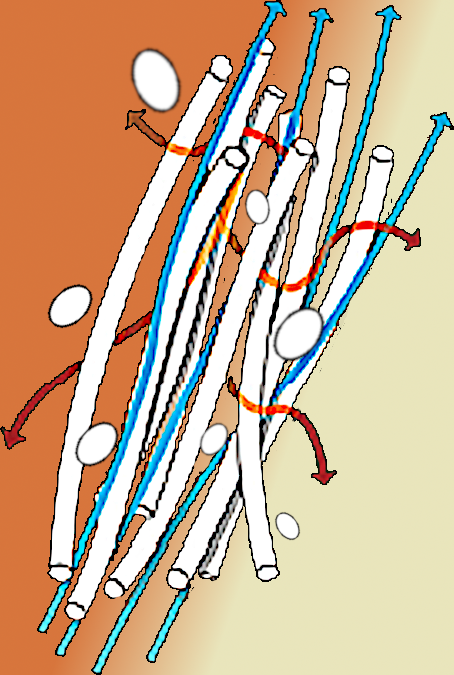
</p>


Indeed, the most immediate way to generalize the tensor model is through the estimation of a so\-called "Free\-Water compartment", which models the effect coming from water molecules not contained in neural axons or soma cells (the latter two are still modeled with an anisotropic tensor). The FW compartment is assumed to be isotropic and its diffusivity set to a constant value of $3.0\cdot 10^{-3} mm^2 /s$ (free\-water diffusivity at body temperature). Though the interpretation of this signal component is somehow controversial, and might largely depend on the particular characteristics of the diffusion sequence, "Free\-water imaging" is an active research field nowadays and several studies illustrate FW might play a role in neuroinflammation processes and ageing. In this Chapter we will demonstrate how FW can be dealt with <samp>DMRIMatlab</samp>.

<p style="text-align:left">
   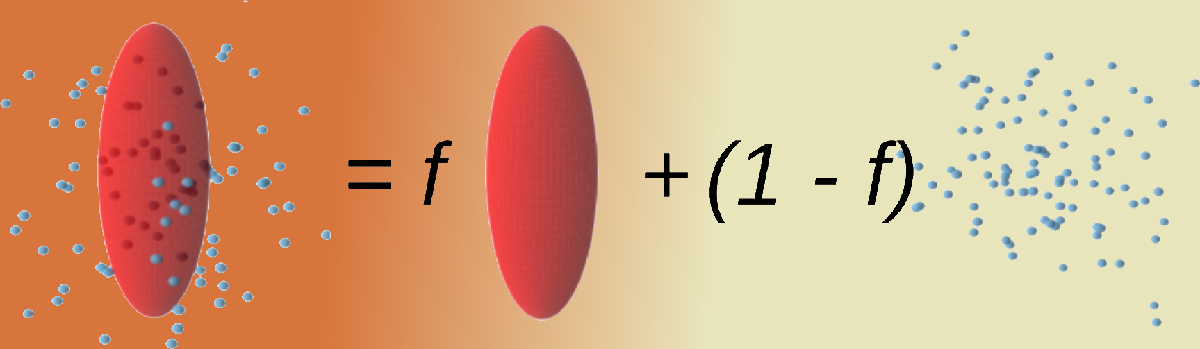
</p>


 ***TO DO:*** Clear all variables and figures to start from zero (*Ctrl+ENTER*):


In [ ]:
addpath('..');
setup__DMRIMatlab_toolbox;
clear;
close('all');

## 1. A note on the required data sets

The estimation of the FW compartment adds new degrees of freedom to the problem, and therefore more sophysticated data sets are required.  **NOTE:** meanwhile single\-shell (with a unique b\-value) data sets suffice to estimate the diffusion tensor, <u>**FW\-estimation requires at least two shells with largely different b\-values to be reliable**</u>. Since the diffusion tensor can be used only for b\-values below $2,000s/mm^2$ , FW+DTI is usually based on data sets with two b\-values under this one. Let's load one such data sets (*Ctrl+ENTER*):


In [ ]:
whos -file test_data2.mat
load test_data3.mat
unique(bi)'
% Keep only those shells with a maximum b-value near 2000:
valid = (bi<=2100);
atti = atti(:,:,:,valid);
gi = gi(valid,:);
bi = bi(valid,1);
size(bi), % How many gradients remain


 ***QUIZ:***


 *The b\-values at each shell are not exactly constant. For example, the first four b\-values are 990, 995, 1000 and 1005* $s/mm^2$ *. Can you determine the actual shells present in the data set and keep the first two shells in a "cleaner" way?* ***HINT:*** *check the function* *<samp>auto_detect_shells</samp>*

<pre>
help auto_detect_shells
</pre>

Besides, note that the estimation of FW+DTI is noticeably more complex than estimating just DTI, therefore computationally more demanding. We will work on just three axial slices of the volume to keep a reasonable computational load:


In [ ]:
slices = [6,9,11];
atti = atti(:,:,slices,:);
mask = mask(:,:,slices);

## 2. Directly estimating the FW and DTI compartments

The FW+DTI representation can be modeled as $(1-f)\cdot {\mathrm{F}\mathrm{r}\mathrm{e}\mathrm{e}-\mathrm{W}\mathrm{a}\mathrm{t}\mathrm{e}\mathrm{r}}+f\cdot {\mathrm{A}\mathrm{n}\mathrm{i}\mathrm{s}\mathrm{o}\mathrm{s}\mathrm{t}\mathrm{r}\mathrm{o}\mathrm{p}\mathrm{i}\mathrm{c}~\mathrm{D}\mathrm{T}-\mathrm{M}\mathrm{R}\mathrm{I}}$ , where it is necessary to find the volume fraction $f$ and the 6 components of the DT (note the FW component is completely determined by the constant, fixed FW diffusivity). This can be done with the function <samp>atti2freewaterTensor</samp>:

<pre>
help atti2freewaterTensor
</pre>

In [ ]:
% The minimum required arguments are the attenuation signal atti and the
% information required to interpret it, i.e. gi and bi:
tic;
[f,dti] = atti2freewaterTensor( atti, gi, bi, ...
    'mask', mask, ... % Use a mask to avoid unnecessary computations
    'O1', true, ... % Level 1, brute-force optimization
    'O2', false, ... % Please, set this to false ALWAYS!
    'O3', true, ... % Actual Newton-Raphson's iterations
    'rcm', 1.0e-5, ... % Minimum allowed condition number
    'pos', false ...
    );
fprintf(1,'It took %1.3f seconds to estimate f\n',toc);


***QUIZ:***


*What does the '<samp>pos</samp>' argument means?* ***HINT:*** *Check the function* *<samp>atti2freewaterTensor</samp>* *. Besides, you can try to switch between*  *<samp>true</samp>* *and* *<samp>false</samp>*  *and check the effects.*

<pre>
help atti2freewaterTensor
</pre>

<samp>Let's check how the FW map looks like:</samp>


In [ ]:
close(figure(1));
hf1 = figure(1);
set(hf1,'Position',[1,1,800,350]);
plotSlicedVolume_demo1(hf1,f,mask,[1,2,3],true);


As you can see, the FW map is noisier than DTI\-derived maps, but still anatomically coherent: all values in the white and gray matter are close to 1 (i.e. there is a small amount of FW), meanwhile the cerebrospinal fluid contains much smaller values (ideally, they should be 0; in practice, it depends a lot on the gradients scheme and the acquisition sequence).


It is interesting to check the differences in the estimated DTI whether or not we eliminate the FW compartment. The variable <samp>dti</samp> returned by <samp>atti2freewaterTensor</samp> itself already accounts for the FW\-corrected DTI. Let's compute the original DTI without FW\-correction and compare both of them:


In [ ]:
dti2 = atti2dti( atti, gi, bi, 'mask', mask, 'wls', true, 'nonlinear', true );
[u1,~,~,l1,l2,l3] = dti2spectrum( dti, 'mask', mask );
[u12,~,~,l12,l22,l32] = dti2spectrum( dti2, 'mask', mask );
colored = spectrum2colorcode( u1, l1, l2, l3, 'mask', mask );
colored2 = spectrum2colorcode( u12, l12, l22, l32, 'mask', mask );
close(figure(2));
hf2 = figure(2);
plotSlicedVolume_demo1(hf2,colored,mask,[1,2,3],true);
title('FW-corrected');
close(figure(3));
hf3 = figure(3);
plotSlicedVolume_demo1(hf3,colored2,mask,[1,2,3],true);
title('non-FW-corrected');


The orientations and white\-to\-gray matter contrast are well preserved with the FW correction. However the brightness and saturation of the colored regions are increased thanks to the removal of the isotropic contaminant. Note that noise and artifcats may appear at some places, but they are mostly located inside the cerebrospinal fluid (which should be 100% FW, hence the DTI signal left is unreliable).

## 3. Ad hoc estimation of FW and retrospective signal correction

The model in the previous section, despite isolating the effect of the FW compartment, is still compromised by the limitations of the DTI representation in anisotropic voxels, mainly: it is prone to biases introduced by the presence of crossing, bending or kissing fibers. To overcome this problem, it is possible to use a two step strategy.

### 3.1 Estimation of the FW compartment from multi\-shell data

Without entering into mathematical details, the so-called spherical means technique allows to infer the micro-structure of the voxel, regardless on the number of crossing fibers, by averaging the behavior of the diffusion signal for all possible spatial orientations. The function to use takes the attenuation signal (and its associated information) as an input, and returns the partial volume fraction of FW. Hence, it is named <samp>atti2freewater</samp>:

<pre>
help atti2freewater
</pre>

The algorithm depends on a regularization parameter 'nu' to properly work, and it must be carefully set. Fortunately, the optimal value of 'nu' depends just on the gradients table, so that we can use the function in "query search mode" to find out such value (*Ctrl+ENTER*):


In [ ]:
[~,~,nu,lpar] = atti2freewater( [], gi, bi, 'nu', nan ); % The 'nan' value forces query search.
fprintf(1,'The algorithm parameters to be used: nu=%1.3f; lpar=%1.3e\n',nu,lpar);

Note 'lpar' can be optimized too by setting <'lpar', nan> as an additional optional argument. For now, we will use the default value. With this value, we can actually perform the estimation:

In [ ]:
% As always, the minimum required information is the attenuation signal
% atti and the information required to interpret it, gi and bi: 
tic;
f2 = atti2freewater( atti, gi, bi, 'nu', nu, 'lpar', lpar, 'mask', mask );
fprintf(1,'It took %1.3f seconds to estimate the FW compartment\n',toc);

***QUIZ:***

*Can you repeat the estimation with simultaneous optimal values of both 'nu' and 'lpar'?*

<pre>
help atti2freewater
</pre>

Let's check how thinks look like with this method:

In [ ]:
close(figure(4));
hf4 = figure(4);
set(hf4,'Position',[1,1,800,350]);
plotSlicedVolume_demo1(hf4,f2,mask,[1,2,3],true);


Pretty similar to the naked eye, as one might have expected.

### 3.2. Retrospective correction of the attenuation signal with the FW compartment

Remember that the FW model assumes the signal is the sum of an isotropic compartment with known diffusivity plus an anisotropic part. Hence, we can just remove the isotropic compartment from the original signal to retrieve the anisotropic signal of interest:


In [ ]:
% Diffusivity of FW at body temperature:
Diso = 3.0e-3; % in mm^2/s
% Isotropic model for diffusion:
Siso = exp( -Diso.*bi );
% Note Siso is a column vector. We will swap its dimensions to place the
% different b-values in the fourth dimension:
size(Siso),
Siso = permute( Siso, [2,3,4,1] );
size(Siso),
% Now, multiply this array times (1-f) to retrieve the isotropic part of
% the signal. Note f (hence 1-f) has size X x Y x Z. When we multiply it by
% Siso, which has size 1 x 1 x 1 x G, the result is a "broadcasted"
% operation where all voxels of (1-f) are multiplied by each of the entries
% of Siso to get an array with size X x Y x Z x G, the same size as the
% attenuation signal:
Siso = Siso.*(1-f);
size(Siso),
size(atti),
% So we can just subtract teh isotropic signal from the original signal to
% get the corrected signal (anisotropic part):
attianiso = atti - Siso;

### 3.3. DTI computation from the corrected signal

Since <samp>attianiso</samp> is a corrected signal with the same size and the same meaning as <samp>atti</samp>, we can directly compute a DTI from it as we have already done many times and check the results:


In [ ]:
dti3 = atti2dti( attianiso, gi, bi, 'mask', mask, 'wls', true, 'nonlinear', true );
[u13,~,~,l13,l23,l33] = dti2spectrum( dti3, 'mask', mask );
colored3 = spectrum2colorcode( u13, l13, l23, l33, 'mask', mask );
close(figure(5));
hf5 = figure(5);
plotSlicedVolume_demo1(hf5,colored3,mask,[1,2,3],true);
title('FW-corrected');



[Go back to index page](./tour_00index.ipynb)


[Previous](./tour_03dtmri.ipynb)


[Next](./tour_05advanced.ipynb)

